In [1]:
import os
import random
import numpy as np
import pandas as pd
from scvi.dataset import RetinaDataset
from scvic.dataset import ExpressionDataset
from scvic.models import CVAE
from scvic.inference import CTrainer
import scanpy as sc
import anndata
import torch

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%matplotlib inline 

# Sets torch and numpy random seeds, run after all scvi imports
seed = 1 
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 

sc.set_figure_params(figsize=(6, 6), frameon=False)

In [2]:
save_path = "/data/Bear/scVIC/notebooks/Datasets/Biological Datasets"
gene_dataset = RetinaDataset(save_path=save_path)
gene_dataset.filter_genes_by_count(per_batch=True)
gene_dataset.make_gene_names_lower()
gene_dataset.subsample_genes(4000)
retina_dataset = ExpressionDataset()
retina_dataset.load_dataset_from_scVI(gene_dataset)

[2024-05-12 21:27:40,201] INFO - scvi.dataset.dataset | File /data/Bear/scVIC/notebooks/Datasets/Biological Datasets/retina.loom already downloaded
[2024-05-12 21:27:40,203] INFO - scvi.dataset.loom | Preprocessing dataset
[2024-05-12 21:27:49,558] INFO - scvi.dataset.loom | Finished preprocessing dataset
[2024-05-12 21:27:54,041] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2024-05-12 21:27:54,044] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2024-05-12 21:27:54,534] INFO - scvi.dataset.dataset | Downsampling from 13166 to 13085 genes
[2024-05-12 21:28:03,887] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2024-05-12 21:28:05,128] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2024-05-12 21:28:14,621] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2024-05-12 21:28:14,993] INFO - scvi.dataset.dataset | Downsampled from 19829 to 19829 cells
[2024-05-12 21:28:14,994] INFO - scvi.dataset

In [3]:
n_epochs = 400
lr = 0.001
use_cuda = True
use_batches = True

In [4]:
retina_cvae = CVAE(retina_dataset.nb_genes, n_labels=retina_dataset.n_labels, n_batch=retina_dataset.n_batches * use_batches, n_latent=10)
ctrainer = CTrainer(
    retina_cvae,
    retina_dataset,
    train_size=1.0,
    use_cuda=use_cuda,
    n_epochs_kl_warmup=200,
    n_epochs_pre_train=200
)

ctrainer.train(n_epochs=n_epochs, lr=lr)

[2024-05-12 21:28:28,894] INFO - scvi.inference.inference | KL warmup for 200 epochs


In [5]:
full = ctrainer.create_posterior(ctrainer.model, retina_dataset, indices=np.arange(len(retina_dataset)))
# Updating the "minibatch" size after training is useful in low memory configurations
latent, labels = full.sequential().get_latent()
de_factor = full.sequential().bayes_factors()
denoised_scale = full.sequential().denoised_scale()

In [6]:
post_adata = anndata.AnnData(X=retina_dataset.X)
post_adata.var_names = de_factor.index.astype(str)
post_adata.obsm["X_scVIC"] = latent
post_adata.obs['cell_type'] = np.array([retina_dataset.cell_types[retina_dataset.labels[i][0]]  
                                        for i in range(post_adata.n_obs)])
post_adata.obs['batch'] = np.array([str(retina_dataset.batch_indices[i][0])
                                   for i in range(post_adata.n_obs)])
labels_pred=pd.Series(labels.astype(str).tolist(), index=post_adata.obs.index, dtype='category')
post_adata.obs['predicted_type'] = labels_pred
post_adata.layers["denoised_scale"] = denoised_scale
sc.pp.neighbors(post_adata, use_rep="X_scVIC", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.3)
show_plot = True

In [7]:
filter_factor = {}
for col in de_factor.columns:
    large_values = de_factor[col][de_factor[col] > 3]
    top = large_values.nlargest(2).index.tolist()
    filter_factor[str(col)] = top

In [8]:
sc.tl.dendrogram(post_adata, groupby="predicted_type", use_rep="X_scVIC")

... storing 'cell_type' as categorical
... storing 'batch' as categorical


categories: 0, 10, 11, etc.
var_group_labels: 0, 1, 2, etc.


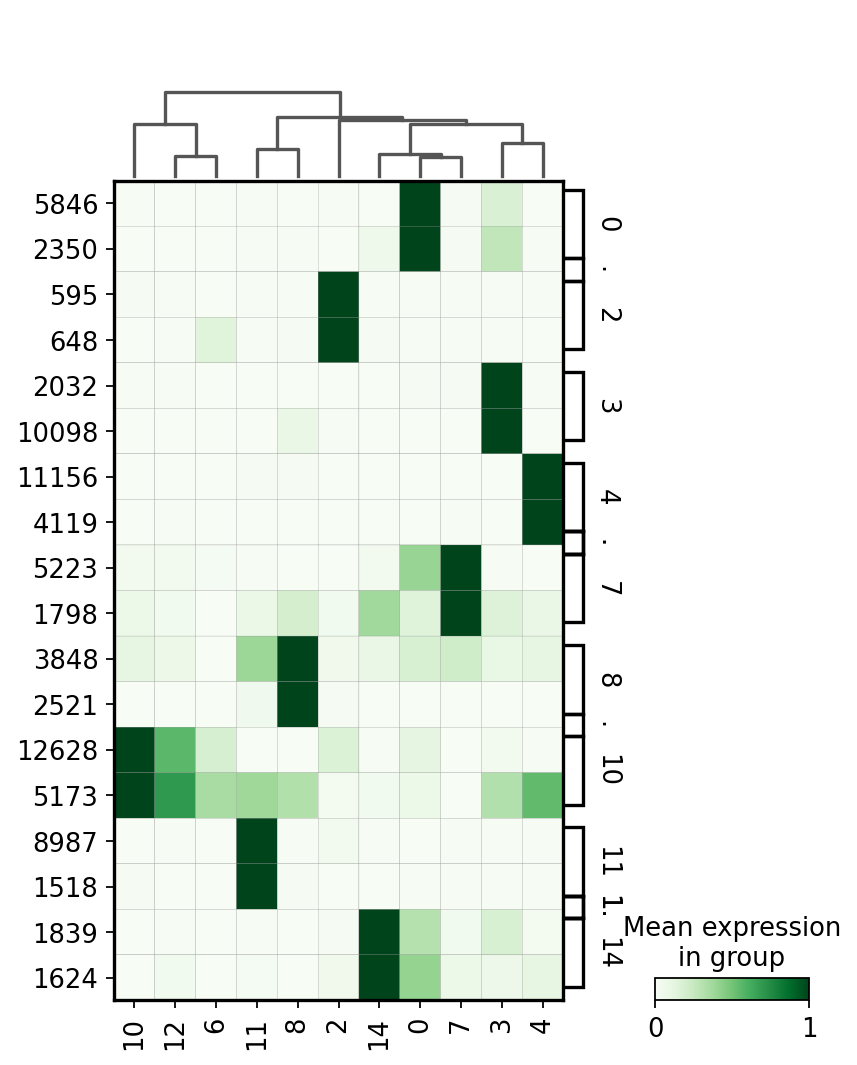

In [9]:
fig = sc.pl.matrixplot(
    post_adata,
    filter_factor,
    groupby="predicted_type",
    dendrogram=True,
    swap_axes=True,
    cmap="Greens",
    standard_scale="var",
    return_fig=True,
)
fig.savefig("Matrix_plot_on_raw_gene_expression.pdf", dpi=300, bbox_inches="tight")

categories: 0, 10, 11, etc.
var_group_labels: 0, 1, 2, etc.


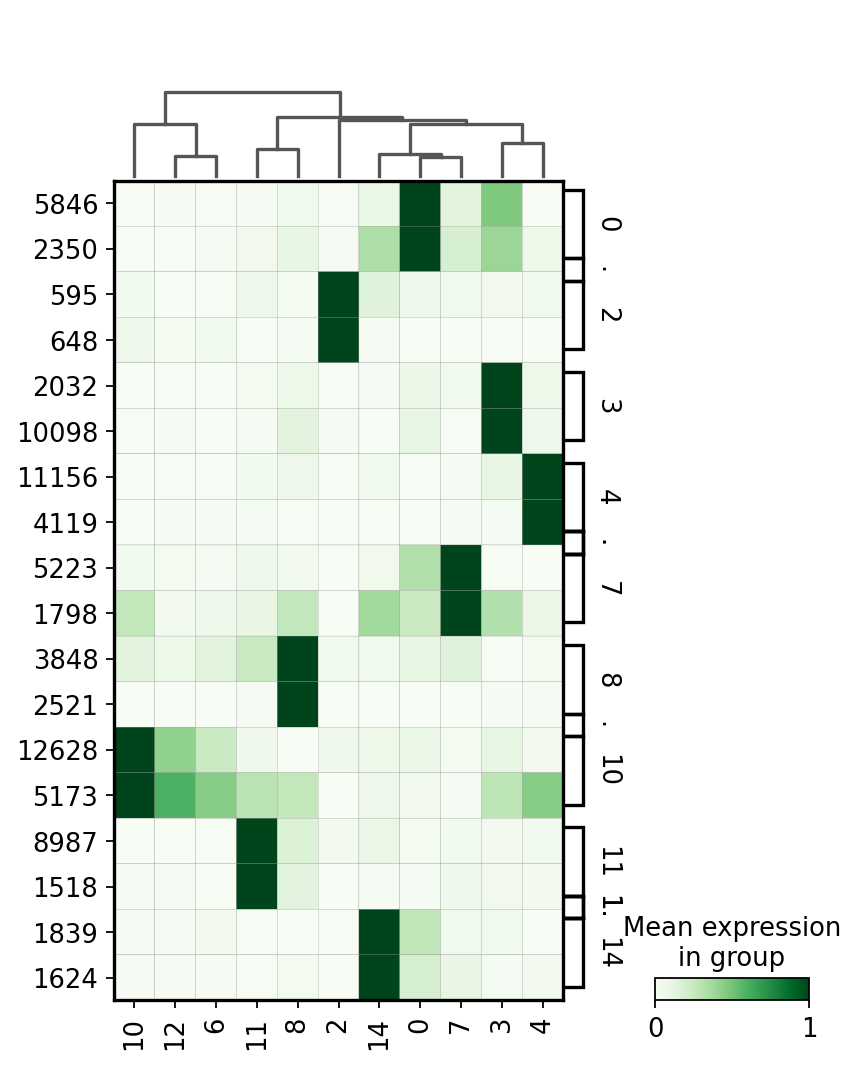

In [10]:
fig = sc.pl.matrixplot(
    post_adata,
    filter_factor,
    groupby="predicted_type",
    dendrogram=True,
    swap_axes=True,
    cmap="Greens",
    standard_scale="var",
    layer="denoised_scale",
    return_fig=True,
)
fig.savefig("Matrix_plot_on_denoised_scale.pdf", dpi=300, bbox_inches="tight")

In [11]:
gene_list = [item for sublist in filter_factor.values() for item in sublist]
show_list = []
for i in range(0, len(gene_list), 2):
    show_list.extend(gene_list[i:i+2])
    if i + 2 < len(gene_list):
        show_list.append("predicted_type")
show_list = ["predicted_type"] + show_list

In [12]:
from matplotlib.colors import LinearSegmentedColormap

colors = ["lightgray", "red"]
cmap = LinearSegmentedColormap.from_list("lightgray_to_red", colors)

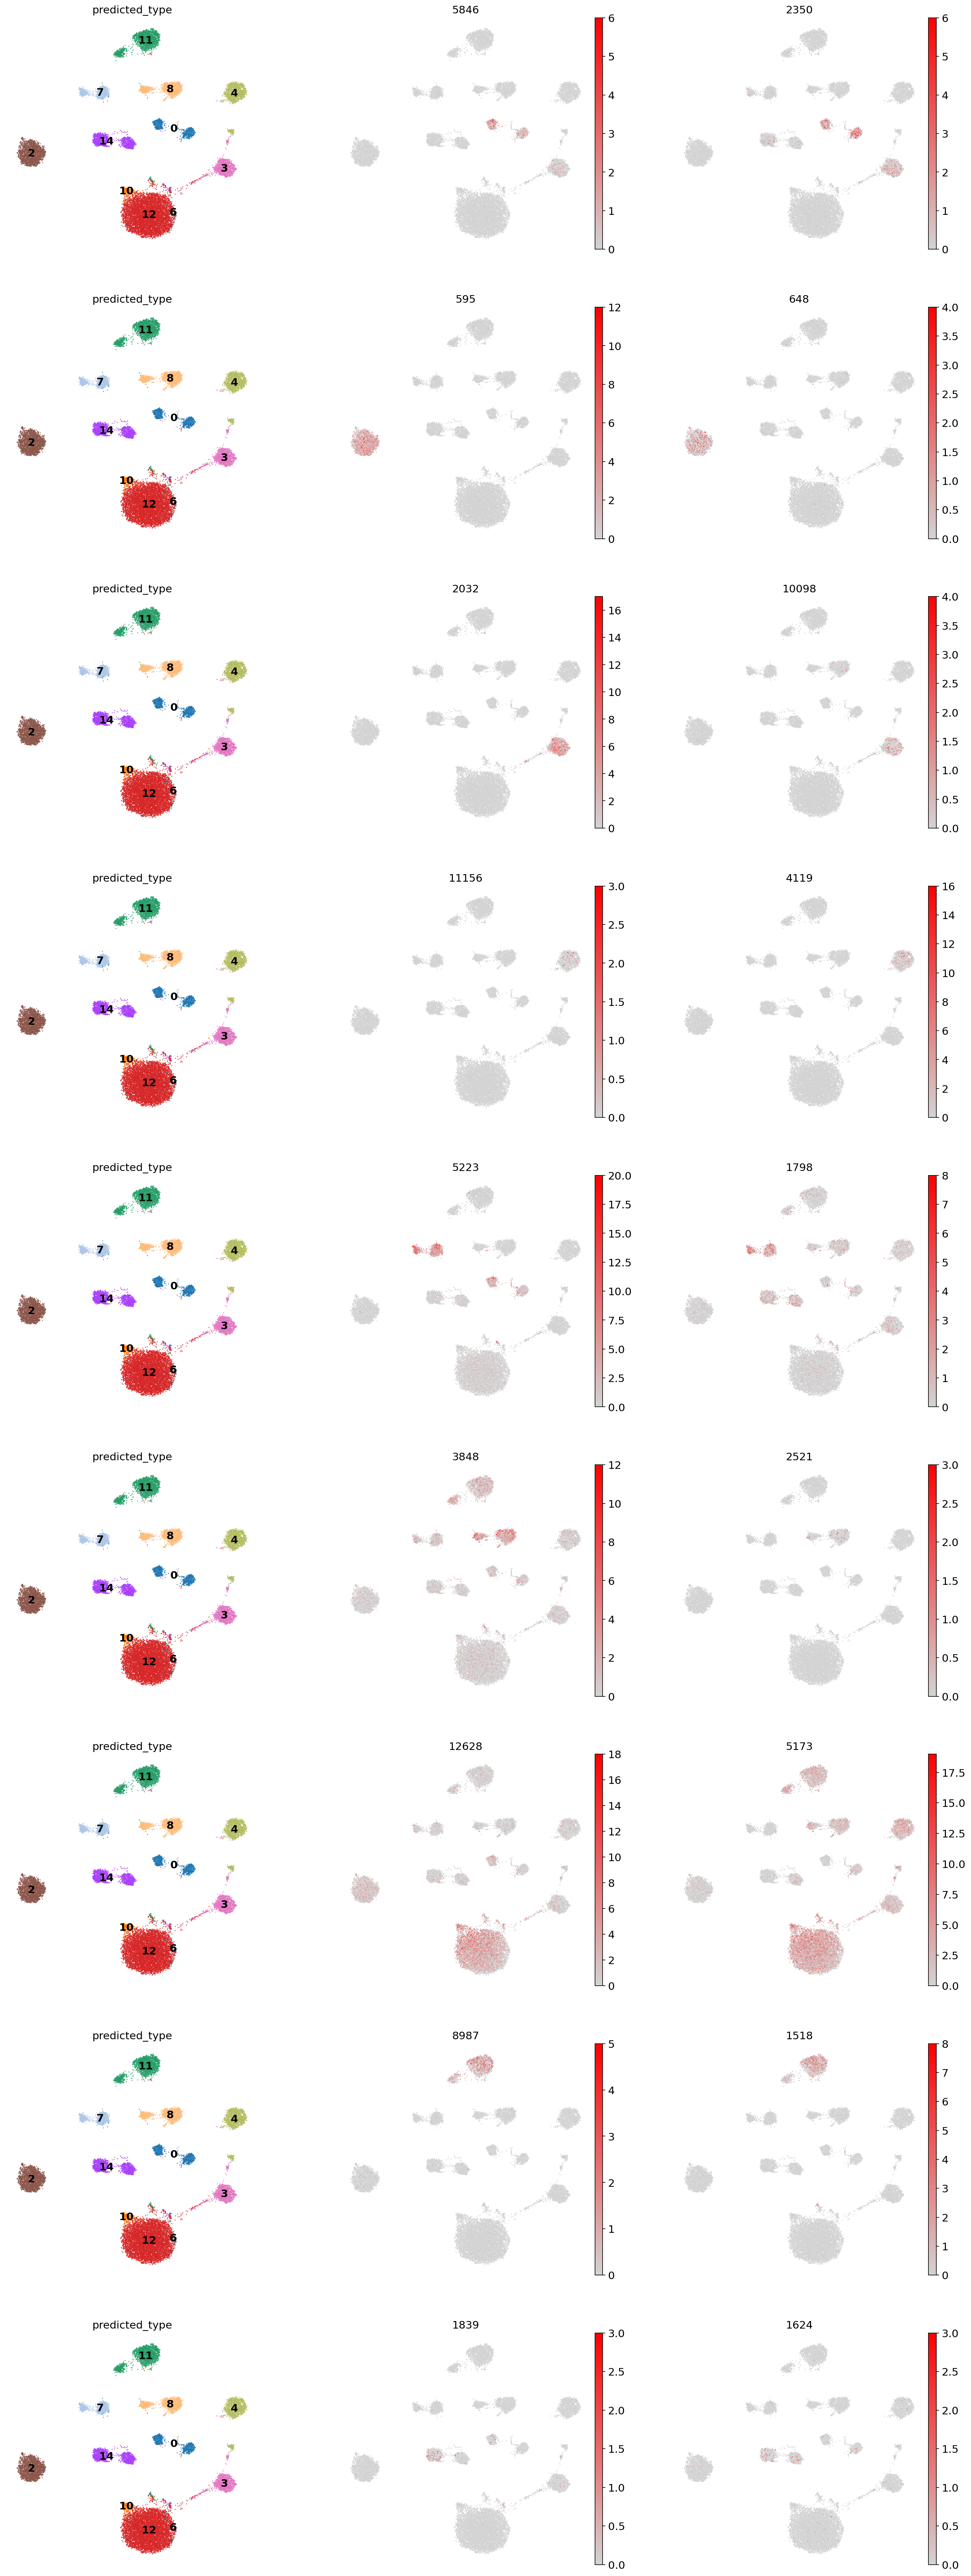

In [13]:
fig = sc.pl.umap(
    post_adata,
    color=show_list,
    legend_loc="on data",
    frameon=False,
    ncols=3,
    wspace=0.2,
    color_map=cmap,
    return_fig=True,
)
fig.savefig("DE_on_gene_expression.pdf", dpi=300, bbox_inches="tight")

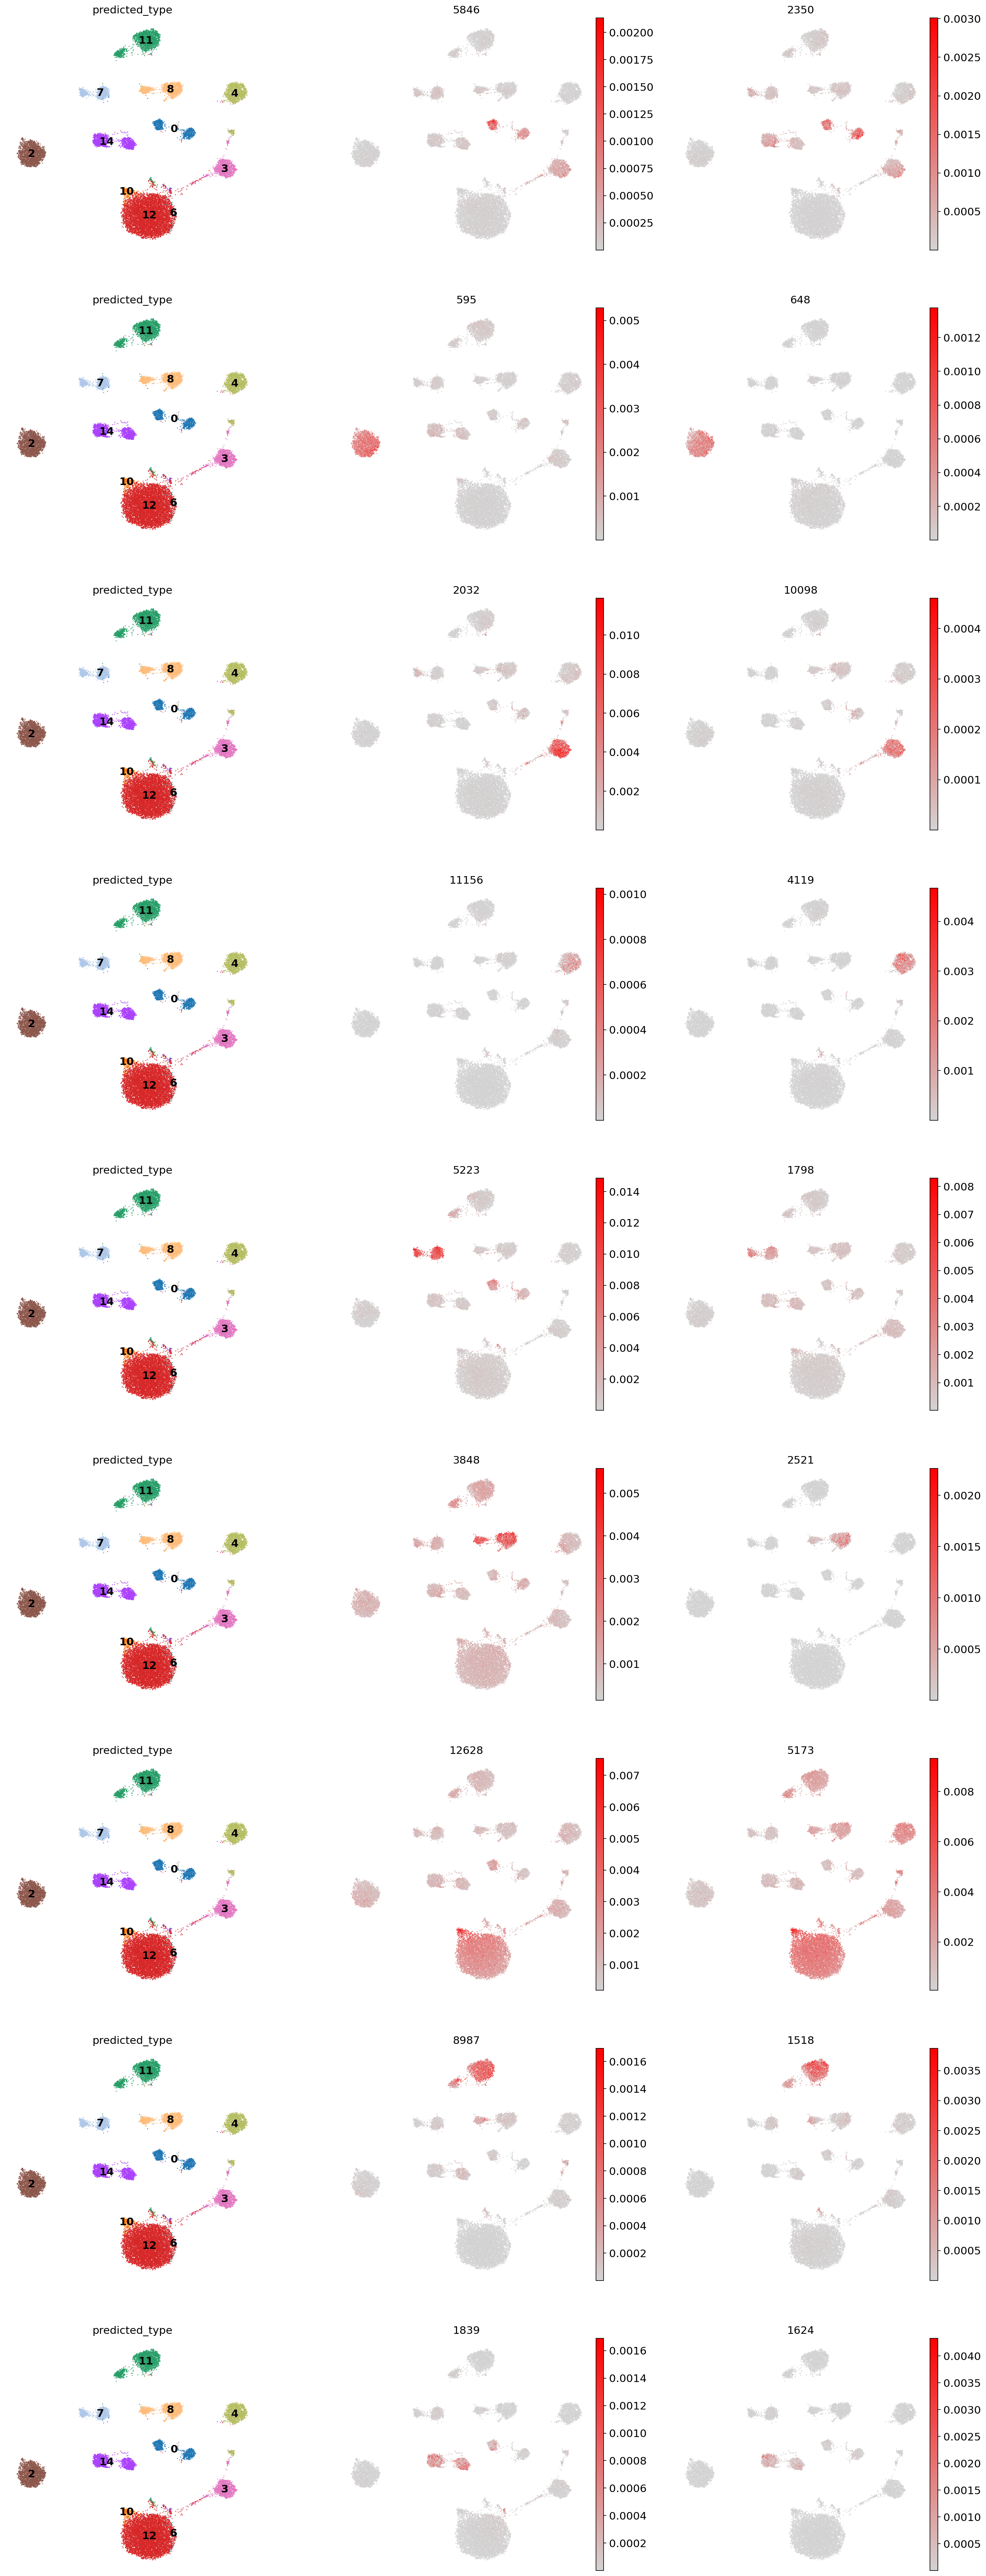

In [14]:
fig = sc.pl.umap(
    post_adata,
    color=show_list,
    legend_loc="on data",
    frameon=False,
    ncols=3,
    wspace=0.2,
    color_map=cmap,
    layer="denoised_scale",
    return_fig=True,
)
fig.savefig("DE_on_denoised_scale.pdf", dpi=300, bbox_inches="tight")

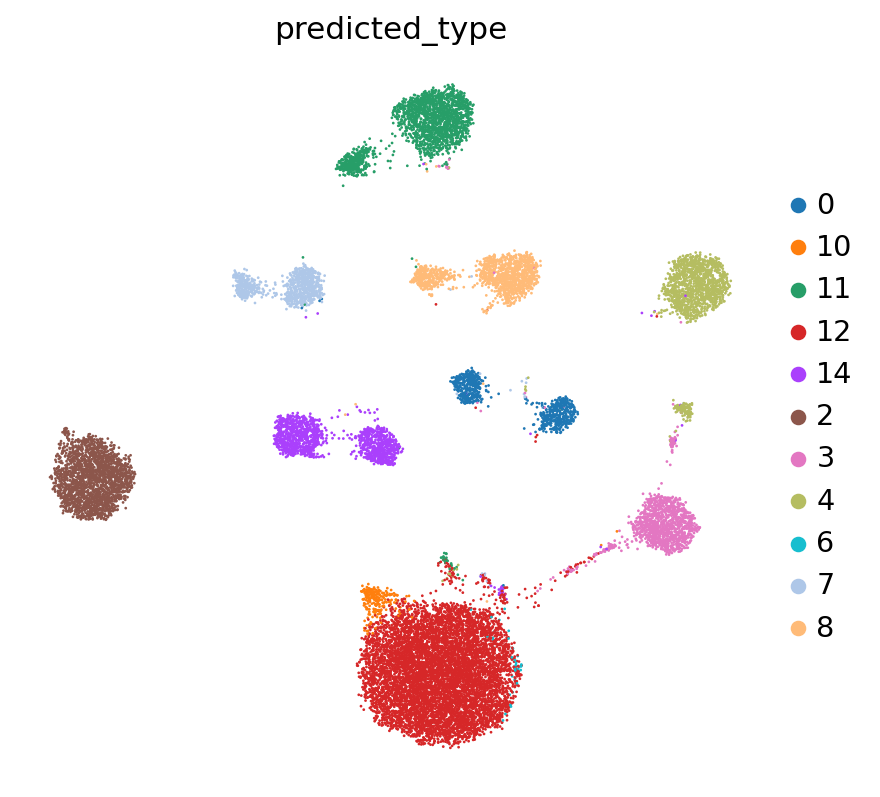

In [15]:
fig = sc.pl.umap(
    post_adata,
    color="predicted_type",
    frameon=False,
    return_fig=True,
)
fig.savefig("legend.pdf", dpi=300, bbox_inches="tight")